In [1]:
%matplotlib inline

In [2]:
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations, test_samples, X=None, Y=None, Z=None, src_si_len=0, \
                 tgt_si_len=0, lang_pair_si_len=0, src_index=None, tgt_index=None, model=None, num_running=0):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)                  : src-tgt language rating matrix
        - K (int)                      : number of latent dimensions
        - alpha (float)                : learning rate
        - beta (float)                 : regularization parameter
        - X (dict)                     : source language side information
        - Y (dict)                     : target language side information
        - Z (dict)                     : language pair side information
        - src_si_len(int)              : source language side information length
        - tgt_si_len(int)              : target language side information length
        - lang_pair_si_len(int)        : language pair side information length
        """

        self.R = np.array(R)
        self.Prediction = deepcopy(self.R)
        self.src_langs = R.index.tolist()
        self.tgt_langs = R.columns.tolist()
        self.num_src, self.num_tgt = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.X = X
        self.Y = Y
        self.Z = Z
        self.src_si_len = src_si_len
        self.tgt_si_len = tgt_si_len
        self.lang_pair_si_len = lang_pair_si_len
        self.test_samples = test_samples
        self.src_index=src_index 
        self.tgt_index=tgt_index
        self.model=model
        self.num_running = num_running
        self.score_dict = {'BLEU': "WIKI-MT", "Muse": "BLI-Muse", "Vecmap": "BLI-Vecmap"}
        self.traing_error_log=[]
        self.test_error_log=[]
        

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_src, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_tgt, self.K))

        # Initialize side information's parameter if necesary
        if self.X and self.src_si_len:
            self.A = np.random.normal(scale = 1./self.src_si_len, size=self.src_si_len)
        if self.Y and self.tgt_si_len:
            self.B = np.random.normal(scale = 1./self.tgt_si_len, size=self.tgt_si_len)
        if self.Z and self.lang_pair_si_len:
            self.C = np.random.normal(scale = 1./self.lang_pair_si_len, size=self.lang_pair_si_len)
        
        # Initialize the biases
        # the biases of users and items are initilized as 0
        # the bias of rating is initilized as mean value
        self.b_u = np.zeros(self.num_src)
        self.b_i = np.zeros(self.num_tgt)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples (where rating > 0)
        self.samples = []
        for i in range(self.num_src):
            for j in range(self.num_tgt):
                if self.R[i,j] > 0:
                    cur_tuple = [i, j, self.R[i, j]]
                    src_lang = self.src_langs[i]
                    tgt_lang = self.tgt_langs[j]
                    if self.X:
                        if src_lang in self.X.keys():
                            cur_tuple.append(self.X[src_lang])
                        else:
                            raise KeyError
                    if self.Y:
                        if tgt_lang in self.Y.keys():
                            cur_tuple.append(self.Y[src_lang])
                        else:
                            raise KeyError
                    if self.Z:
                        if src_lang + "_" + tgt_lang in self.Z.keys():
                            cur_tuple.append(self.Z[src_lang + "_" + tgt_lang])
                        else:
                            raise KeyError
                    self.samples.append(tuple(cur_tuple))

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            # shuffle training samples
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 100 == 0:
                self.traing_error_log.append((i, mse))
                test_mse = self.evaluate_testing(self.test_samples, self.src_index, self.tgt_index, self.model)
                self.test_error_log.append((i, test_mse))
#                 print("\t\tIteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
#         predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x][y] - self.Prediction[x][y], 2)
        return np.sqrt(error / len(xs))

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for sample in self.samples:
            i, j, r = sample[0], sample[1], sample[2]
            # Computer prediction and error
            prediction = self.get_rating(sample)
            self.Prediction[i][j] = prediction
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
            
            # Update side information parameter if necessary
            cur_index = 3
            if self.X:
                x = np.array(sample[cur_index], dtype=np.float64)
                cur_index += 1
                self.A += self.alpha * (e * x - self.beta * self.A)
            if self.Y:
                y = np.array(sample[cur_index], dtype=np.float64)
                cur_index += 1
                self.B += self.alpha * (e * y - self.beta * self.B)
            if self.Z:
                z = np.array(sample[cur_index], dtype=np.float64)
                self.C += self.alpha * (e * z - self.beta * self.C)
                

    def get_rating(self, sample):
        """
        Get the predicted rating of sample
        """
        i, j, r = sample[0], sample[1], sample[2]
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        cur_index = 3
        if self.X:
            x = sample[cur_index]
            cur_index += 1
            prediction += self.A.dot(x.T)
        if self.Y:
            y = sample[cur_index]
            cur_index += 1
            prediction += self.B.dot(y.T)
        if self.Z:
            z = sample[cur_index]
            prediction += self.C.dot(z.T)
        return prediction
    
    def evaluate_testing(self, test_data, src_index_name, tgt_index_name, score_index_name):
        """
        Predict the score for testing data
        """ 
        rmse = 0.0
        for record in test_data.iterrows():
            record = record[1]
            src_lang = record[src_index_name]
            tgt_lang = record[tgt_index_name]
            src_lang_index = self.src_langs.index(src_lang)
            tgt_lang_index = self.tgt_langs.index(tgt_lang)
            score = record[score_index_name]
            cur_tuple = [src_lang_index, tgt_lang_index, score]
            if self.X:
                if src_lang in self.X.keys():
                    cur_tuple.append(self.X[src_lang])
                else:
                    raise KeyError
            if self.Y:
                if tgt_lang in self.Y.keys():
                    cur_tuple.append(self.Y[src_lang])
                else:
                    raise KeyError
            if self.Z:
                if src_lang + "_" + tgt_lang in self.Z.keys():
                    cur_tuple.append(self.Z[src_lang + "_" + tgt_lang])
                else:
                    raise KeyError
            prediction = self.get_rating(tuple(cur_tuple))
            rmse += (prediction - score) * (prediction - score)
        return np.sqrt(rmse / len(test_data))
        

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P, Q, A, B, and C
        """
        res = deepcopy(self.R)
        for i in range(self.num_src):
            for j in range(self.num_tgt):
                src_lang = self.src_langs[i]
                tgt_lang = self.tgt_langs[j]
                res[i][j] = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
                if self.X and src_lang in self.X.keys():
                    x = self.X[src_lang]
                    res[i][j] += self.A.dot(x.T)
                if self.Y and tgt_lang in self.Y.keys():
                    y = self.X[tgt_lang]
                    res[i][j] += self.A.dot(x.T)
                if self.Z and src_lang + "_" + tgt_lang in self.Z.keys():
                    z = self.X[src_lang + "_" + tgt_lang]
                    res[i][j] += self.A.dot(x.T)
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    
    def draw_error_curve(self, i):
        import matplotlib.pyplot as plt
        import numpy as np
        iters = []
        train_loss = []
        test_loss = []
        for item in self.traing_error_log:
            iters.append(item[0])
            train_loss.append(item[1])
        for item in self.test_error_log:
            test_loss.append(item[1])

        plt.plot(iters, train_loss, 'b', label='train loss')#'b'指：color='blue'
        plt.plot(iters, test_loss, 'r', label='test loss')#'r'指：color='red'

        plt.legend()  #显示上面的label
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        title = self.score_dict[self.model] + "_" + str(self.num_running+1) + "_Fold" + str(i+1)
        plt.title(title) 
        plt.savefig("../result/without_si/" + self.score_dict[self.model] + "/fold" + str(i+1) + "/" + title + ".png")

        #plt.ylim(-1,1)#仅设置y轴坐标范围
        plt.show()

        

Represent the two tasks above as matrices (BLEU scores for Wiki-MT and Accuracy for BLI) 

In [3]:
import pandas as pd
import numpy as np
np.random.seed(2021)

In [4]:
from copy import deepcopy
import pandas as pd
import random as rd

def split_k_fold_data(file_dir, score_index_name, src_index_name, tgt_index_name, k=5):
    data = pd.read_csv(file_dir)
    
    # shuffle
    data = data.sample(frac=1)
    
    # generate score matrix
    src_langs = data[src_index_name].unique()
    tgt_langs = data[tgt_index_name].unique()
    score_matrix = pd.DataFrame(index = src_langs, columns = tgt_langs)
    
    # eliminate empty rows and columns
    data = data.dropna(axis=1, how="all")
    data = data.dropna(axis=0, how="all")
    
    # K fold split
    k_fold_data = {}
    models = list(score_index_name)
    lens= len(data)
    
    for i, model in enumerate(models):
        ex_per_fold = int(np.ceil(lens / k))
        for j in range(k):
            start = ex_per_fold * j
            end = ex_per_fold * (j + 1)
            if j == 0:
                k_fold_data[model] = {"train": [], "test": []}
            k_fold_data[model]["train"].append(pd.concat([data.iloc[:start, :], data.iloc[end:, :]], axis=0))
            k_fold_data[model]["test"].append(data.iloc[start:end, :])
    return k_fold_data, score_matrix

def generate_score_matrix(train_data, src_index_name, tgt_index_name, score_index_name, origin_score_matrix):    
    score_matrix = deepcopy(origin_score_matrix)
    
    for record in train_data.iterrows():
        record = record[1]
        src_lang = record[src_index_name]
        tgt_lang = record[tgt_index_name]
        score = record[score_index_name]
        score_matrix.loc[src_lang, tgt_lang] = score
#         score_matrix[src_lang][tgt_lang] = score
    for lang in score_matrix.columns:
        score_matrix[lang][lang] = 100.0
    score_matrix.fillna(0, inplace=True)
    return score_matrix

def get_rmse(valid_data, model, src_index_name, tgt_index_name, score_matrix, train_matrix):
    rmse = 0.0
    src_langs = train_matrix.index.tolist()
    tgt_langs = train_matrix.columns.tolist()
    for cur_valid_data in valid_data.iterrows():
        cur_valid_data = cur_valid_data[1]
        src_lang, tgt_lang, score = cur_valid_data[src_index_name], cur_valid_data[tgt_index_name], cur_valid_data[model]
        src_idx = src_langs.index(src_lang)
        tgt_idx = tgt_langs.index(tgt_lang)
        prediction = score_matrix[src_idx][tgt_idx]
        rmse += (prediction - score) * (prediction - score)
    return np.sqrt(rmse / len(valid_data))

def get_result(alpha, beta, data_dir, scores, src_index, tgt_index, k, num_running, src_lang_side_info=None, \
               tgt_lang_side_info=None, lang_pair_side_info=None, src_si_len=0, tgt_si_len=0, \
               lang_pair_si_len=0):
    all_running_rmse = 0.0
    for nr in range(num_running):
        print("num running: " + str(nr+1))
        data, langs_matrix = split_k_fold_data(data_dir, scores, src_index, tgt_index, k)
        
        src_langs = langs_matrix.index.tolist()
        tgt_langs = langs_matrix.columns.tolist()
        
        res = {}
        for model in scores:
            print("-"*40)
            print(model)
            total_rmse = 0.0
            for i in range(k):
                print("\tFold {}: ".format(i+1))
                train_data, test_data = data[model]["train"][i], data[model]["test"][i]
                train_matrix = generate_score_matrix(train_data, src_index, tgt_index, model, langs_matrix)
                mf = MF(train_matrix, K=2, alpha=alpha, beta=beta, iterations=2000, test_samples=test_data, X=src_lang_side_info, \
                        Y=tgt_lang_side_info, Z=lang_pair_side_info, src_si_len=src_si_len, tgt_si_len=tgt_si_len, \
                        lang_pair_si_len=lang_pair_si_len, src_index=src_index, tgt_index=tgt_index, model=model, \
                       num_running=nr)
                trainging_log = mf.train()
#                 predictions = mf.full_matrix()
#                 cur_rmse = get_rmse(test_data, model, src_index, tgt_index, predictions, train_matrix)
                cur_rmse = mf.evaluate_testing(test_data, src_index, tgt_index, model)
                mf.draw_error_curve(i)
                total_rmse += cur_rmse
                print("\t\trmse is {}.".format(cur_rmse))
                print("*" * 20)
                
            average_rmse = total_rmse / k
            print("average rmse: " + str(average_rmse))
            res[model] = average_rmse
        res_rmse = 0.0
        for key, value in res.items():
            res_rmse += value
        all_running_rmse += res_rmse / len(scores)
    return all_running_rmse / num_running

def get_language_pair_side_info(data_dir, side_info_features, src_lang_name, tgt_lang_name):
    data = pd.read_csv(data_dir)
    side_dict = {}
    for record in data.iterrows():
        record = record[1]
        src_lang = record[src_lang_name]
        tgt_lang = record[tgt_lang_name]
        side_dict[src_lang + "_" + tgt_lang] = record[side_info_features].values
    return side_dict

def get_language_side_information(data_dir, src_lang_name, tgt_lang_name):
    
    data = pd.read_csv(data_dir)
    side_dict = {}
    src_langs = set()
    tgt_langs = set()
    
    for record in data.iterrows():
        record = record[1]
        src_lang = record[src_lang_name]
        tgt_lang = record[tgt_lang_name]
        src_langs.add(src_lang)
        tgt_langs.add(tgt_lang)
        
    src_langs = list(src_langs)
    tgt_langs = list(tgt_langs)
        
    return languages_to_features(src_langs), languages_to_features(tgt_langs)

def languages_to_features(languages_list):
    from sklearn.decomposition import PCA
    import lang2vec.lang2vec as l2v
    features_list = ["syntax_knn", "phonology_knn", "inventory_knn"]
    features = l2v.get_features(languages_list, features_list)
    
    features_matrix = []
    for language in languages_list:
        features_matrix.append(features[language])
        
    pca = PCA(n_components=6)   
    pca_features_matrix = pca.fit_transform(features_matrix)
    res = {}
    
    for i, language in enumerate(languages_list):
        res[languages_list[i]] = pca_features_matrix[i]
    return res

num running: 1
----------------------------------------
BLEU
	Fold 1: 


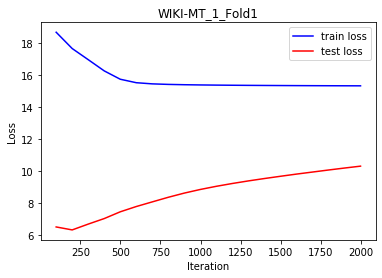

		rmse is 10.317222872423867.
********************
	Fold 2: 


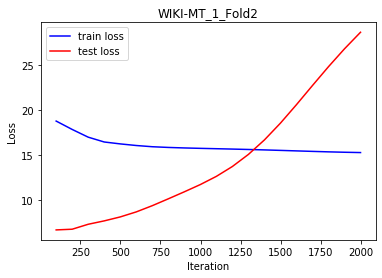

		rmse is 28.64481783413549.
********************
	Fold 3: 


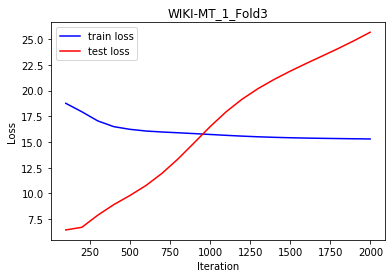

		rmse is 25.67976711138056.
********************
	Fold 4: 


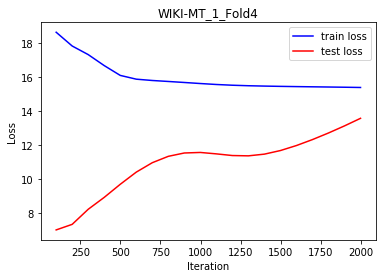

		rmse is 13.573990004692892.
********************
	Fold 5: 


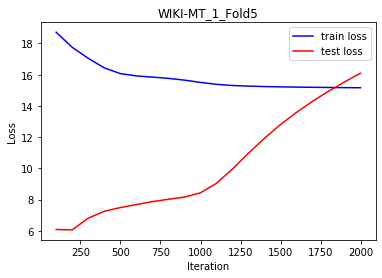

		rmse is 16.091562837506583.
********************
average rmse: 18.861472132027878
num running: 2
----------------------------------------
BLEU
	Fold 1: 


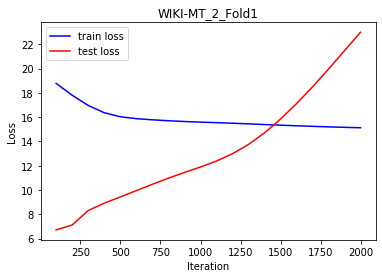

		rmse is 22.993130475760022.
********************
	Fold 2: 


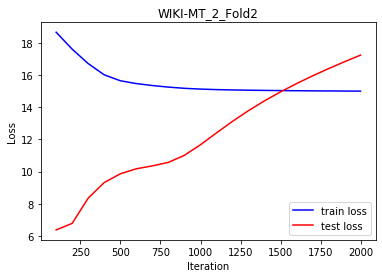

		rmse is 17.233621467188236.
********************
	Fold 3: 


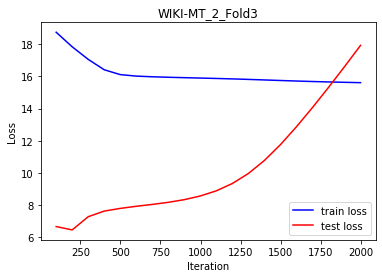

		rmse is 17.928024592429196.
********************
	Fold 4: 


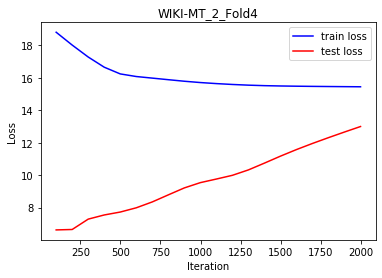

		rmse is 13.003167103477029.
********************
	Fold 5: 


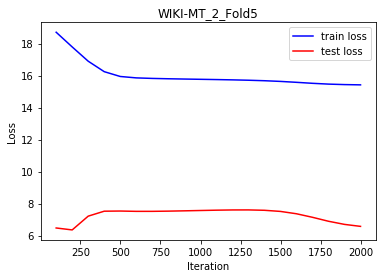

		rmse is 6.578352340674361.
********************
average rmse: 15.547259195905767
num running: 3
----------------------------------------
BLEU
	Fold 1: 


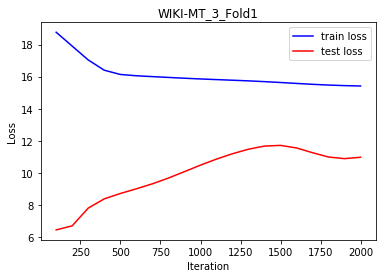

		rmse is 10.983144755694495.
********************
	Fold 2: 


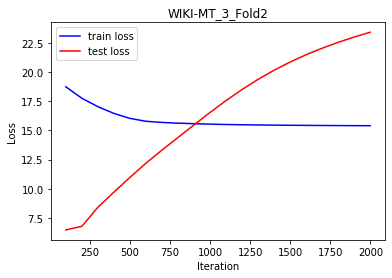

		rmse is 23.403371918969967.
********************
	Fold 3: 


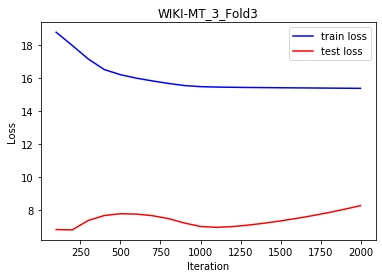

		rmse is 8.282749544045474.
********************
	Fold 4: 


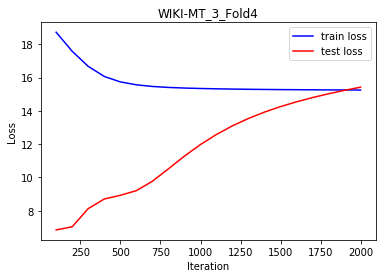

		rmse is 15.42599550509614.
********************
	Fold 5: 


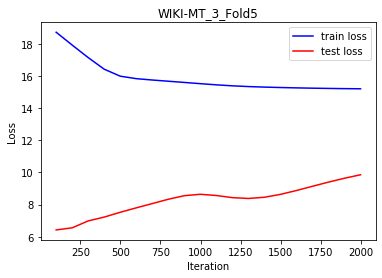

		rmse is 9.855909298603825.
********************
average rmse: 13.590234204481979
num running: 4
----------------------------------------
BLEU
	Fold 1: 


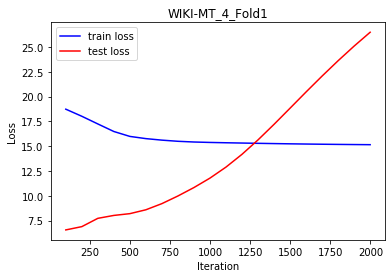

		rmse is 26.483117128324754.
********************
	Fold 2: 


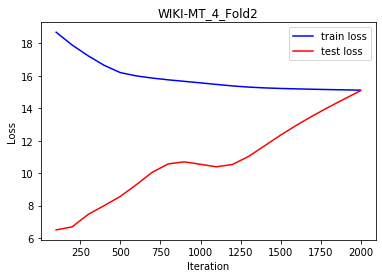

		rmse is 15.083536039043016.
********************
	Fold 3: 


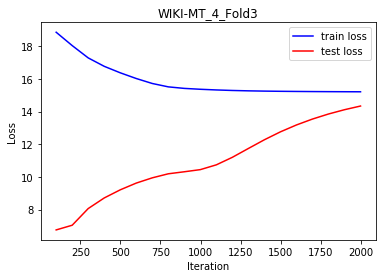

		rmse is 14.335985502671939.
********************
	Fold 4: 


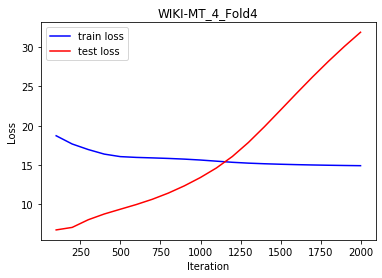

		rmse is 31.877256623373842.
********************
	Fold 5: 


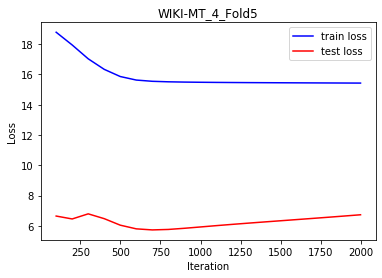

		rmse is 6.727857506997525.
********************
average rmse: 18.901550560082214
num running: 5
----------------------------------------
BLEU
	Fold 1: 


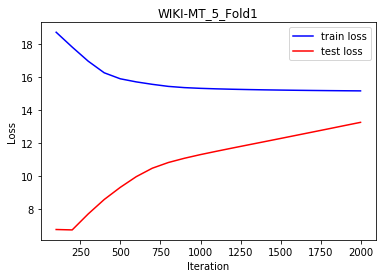

		rmse is 13.254322489200078.
********************
	Fold 2: 


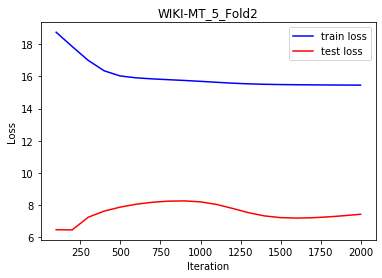

		rmse is 7.421162023388503.
********************
	Fold 3: 


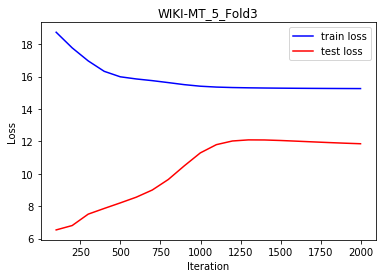

		rmse is 11.852860308770772.
********************
	Fold 4: 


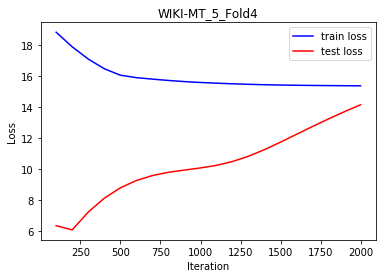

		rmse is 14.136991255522211.
********************
	Fold 5: 


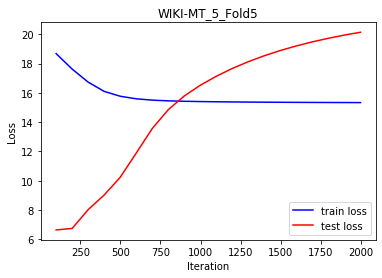

		rmse is 20.14605522360275.
********************
average rmse: 13.362278260096863
num running: 6
----------------------------------------
BLEU
	Fold 1: 


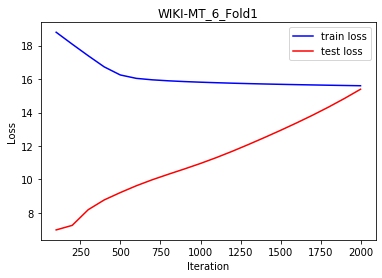

		rmse is 15.39265993893877.
********************
	Fold 2: 


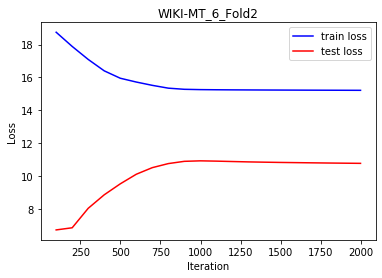

		rmse is 10.776062618612954.
********************
	Fold 3: 


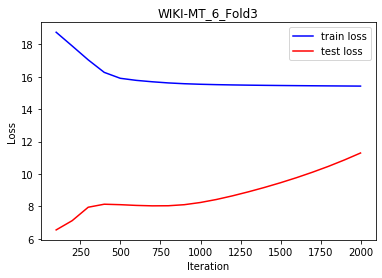

		rmse is 11.293722929343739.
********************
	Fold 4: 


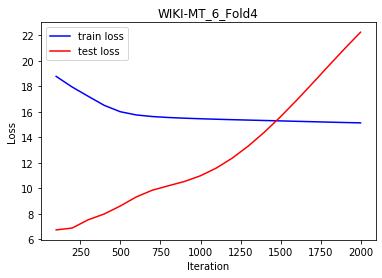

		rmse is 22.228978402872098.
********************
	Fold 5: 


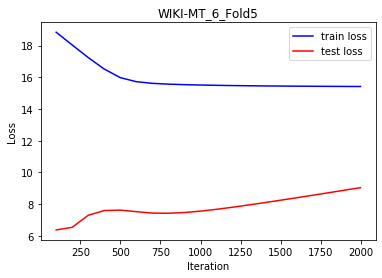

		rmse is 9.039545931202351.
********************
average rmse: 13.746193964193983
num running: 7
----------------------------------------
BLEU
	Fold 1: 


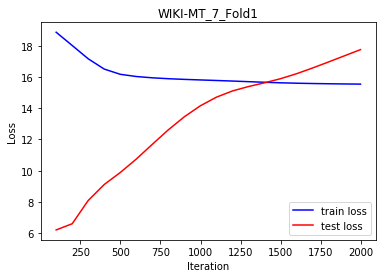

		rmse is 17.759857400270455.
********************
	Fold 2: 


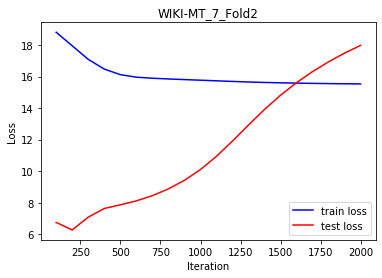

		rmse is 17.97344065299088.
********************
	Fold 3: 


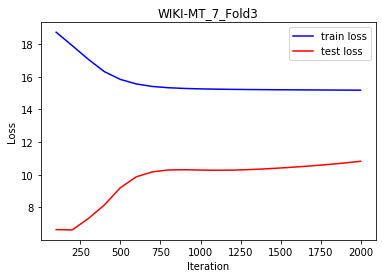

		rmse is 10.821909551301186.
********************
	Fold 4: 


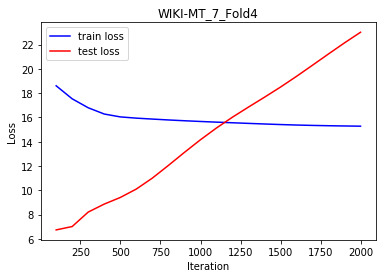

		rmse is 23.02088569229414.
********************
	Fold 5: 


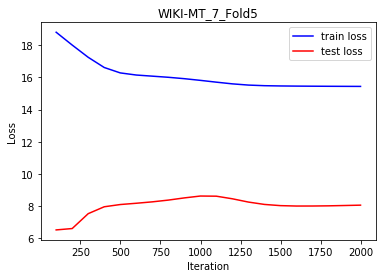

		rmse is 8.049382062848862.
********************
average rmse: 15.525095071941106
num running: 8
----------------------------------------
BLEU
	Fold 1: 


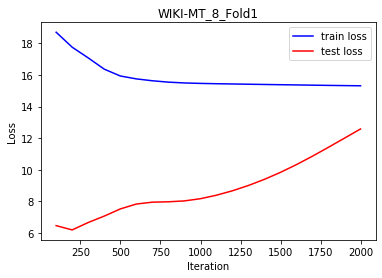

		rmse is 12.585340937478158.
********************
	Fold 2: 


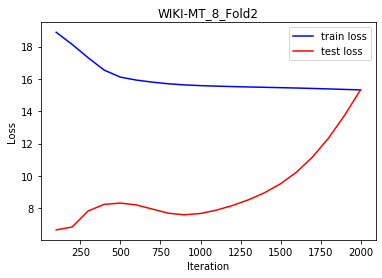

		rmse is 15.329138191017591.
********************
	Fold 3: 


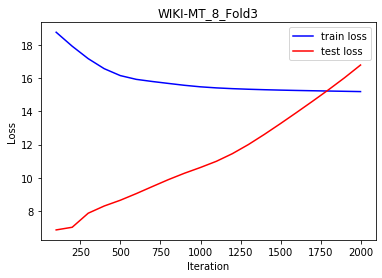

		rmse is 16.783931224400273.
********************
	Fold 4: 


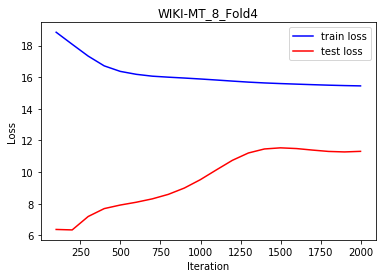

		rmse is 11.309281635606148.
********************
	Fold 5: 


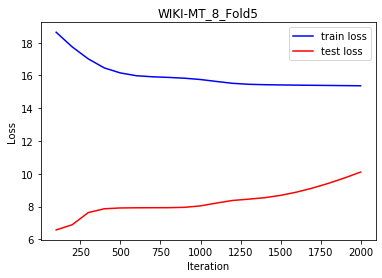

		rmse is 10.104015111690938.
********************
average rmse: 13.222341420038621
num running: 9
----------------------------------------
BLEU
	Fold 1: 


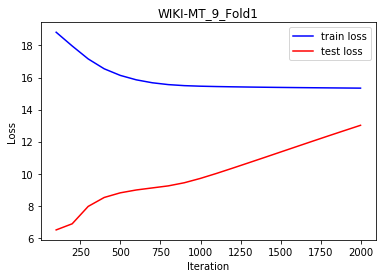

		rmse is 13.018533119996683.
********************
	Fold 2: 


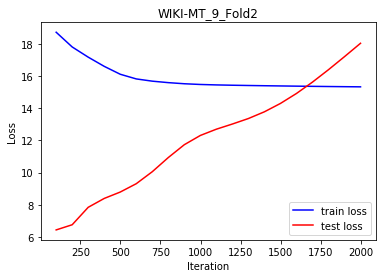

		rmse is 18.04285314369024.
********************
	Fold 3: 


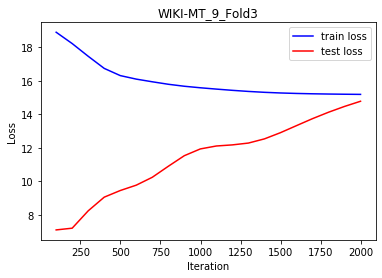

		rmse is 14.772700215836126.
********************
	Fold 4: 


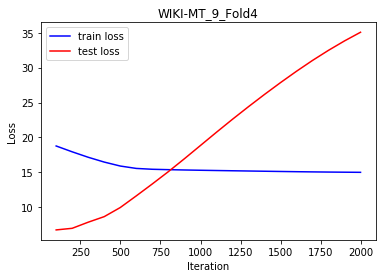

		rmse is 35.0650445912791.
********************
	Fold 5: 


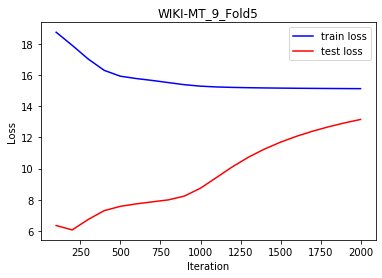

		rmse is 13.157717383572844.
********************
average rmse: 18.811369690875
num running: 10
----------------------------------------
BLEU
	Fold 1: 


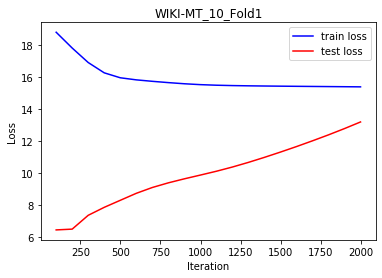

		rmse is 13.182484420240463.
********************
	Fold 2: 


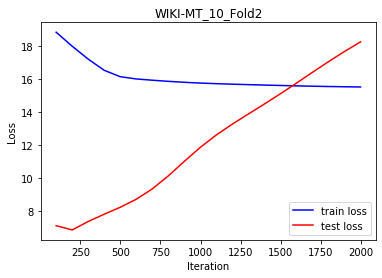

		rmse is 18.27128564003627.
********************
	Fold 3: 


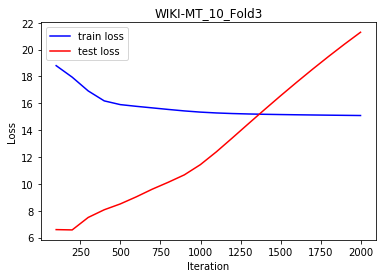

		rmse is 21.29637567791213.
********************
	Fold 4: 


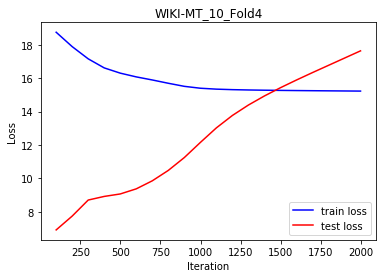

		rmse is 17.635137276211236.
********************
	Fold 5: 


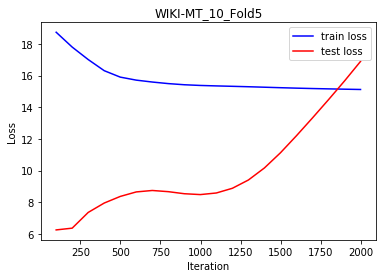

		rmse is 16.894624923188267.
********************
average rmse: 17.455981587517677
num running: 1
----------------------------------------
Muse
	Fold 1: 


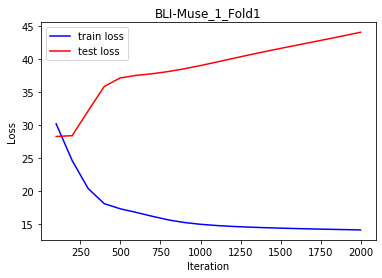

		rmse is 44.0125918931058.
********************
	Fold 2: 


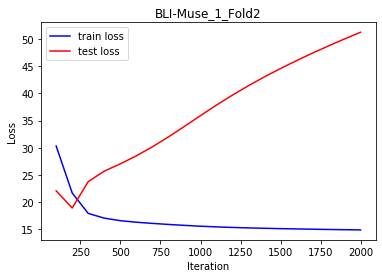

		rmse is 51.289480268545795.
********************
	Fold 3: 


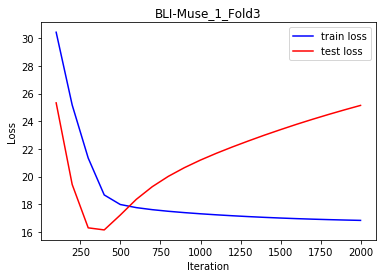

		rmse is 25.14247006095467.
********************
	Fold 4: 


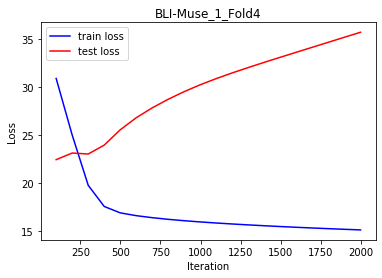

		rmse is 35.68782931650265.
********************
	Fold 5: 


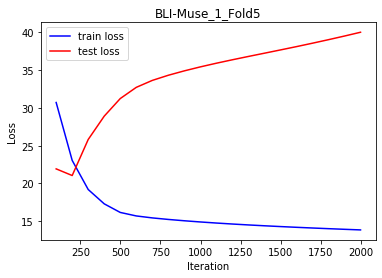

		rmse is 40.03249521222666.
********************
average rmse: 39.23297335026711
----------------------------------------
Vecmap
	Fold 1: 


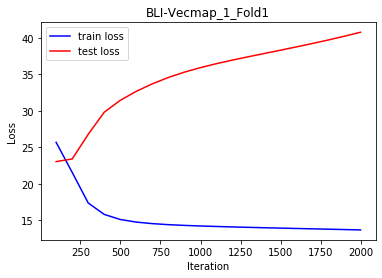

		rmse is 40.780732520353794.
********************
	Fold 2: 


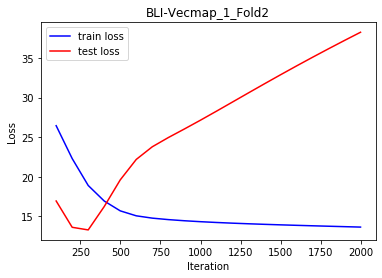

		rmse is 38.251680538564784.
********************
	Fold 3: 


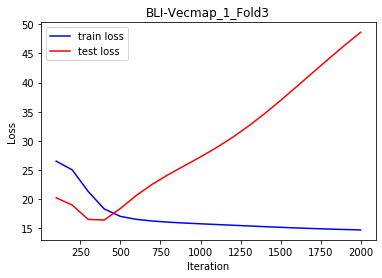

		rmse is 48.64837444338476.
********************
	Fold 4: 


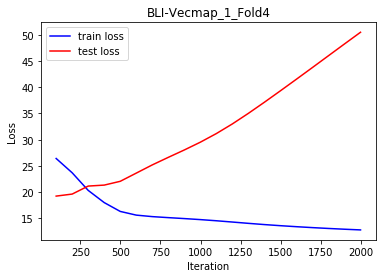

		rmse is 50.47962018068564.
********************
	Fold 5: 


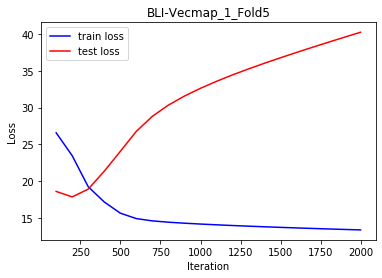

		rmse is 40.22589716749977.
********************
average rmse: 43.67726097009775
num running: 2
----------------------------------------
Muse
	Fold 1: 


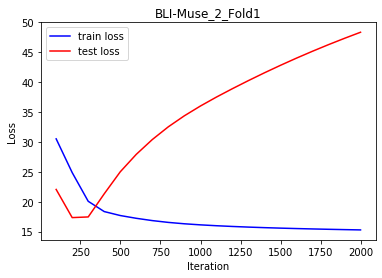

		rmse is 48.354464230819005.
********************
	Fold 2: 


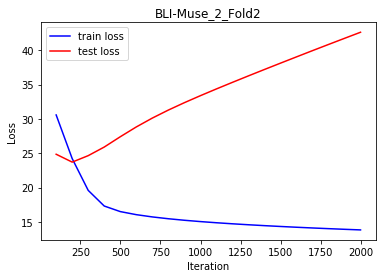

		rmse is 42.60697043833279.
********************
	Fold 3: 


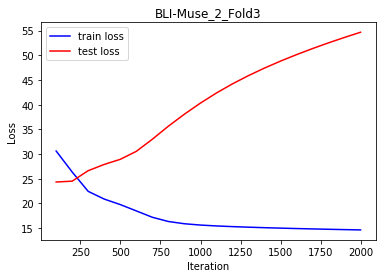

		rmse is 54.67389195331284.
********************
	Fold 4: 


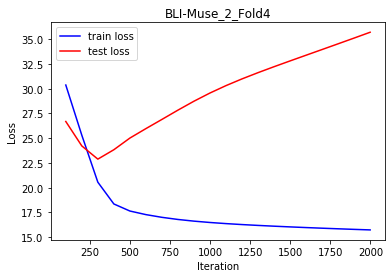

		rmse is 35.698874541499315.
********************
	Fold 5: 


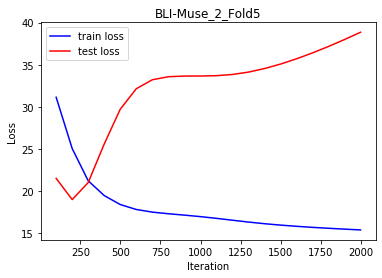

		rmse is 38.85489203182028.
********************
average rmse: 44.037818639156846
----------------------------------------
Vecmap
	Fold 1: 


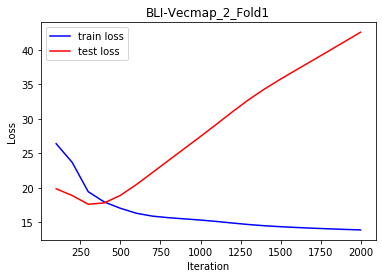

		rmse is 42.56706459387372.
********************
	Fold 2: 


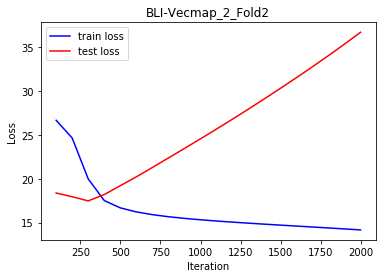

		rmse is 36.72046977794607.
********************
	Fold 3: 


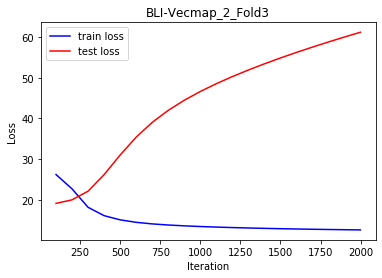

		rmse is 61.17036429536065.
********************
	Fold 4: 


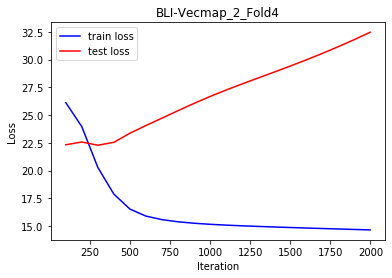

		rmse is 32.45630223925985.
********************
	Fold 5: 


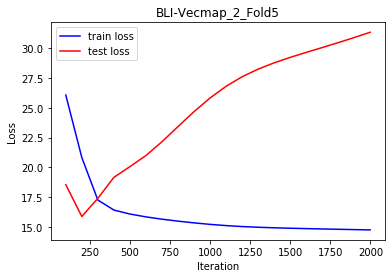

		rmse is 31.329079717236443.
********************
average rmse: 40.84865612473535
num running: 3
----------------------------------------
Muse
	Fold 1: 


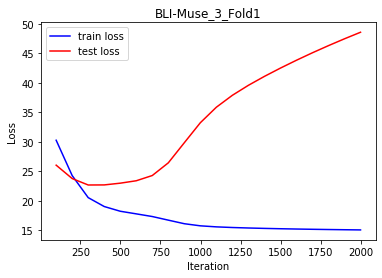

		rmse is 48.553580059946974.
********************
	Fold 2: 


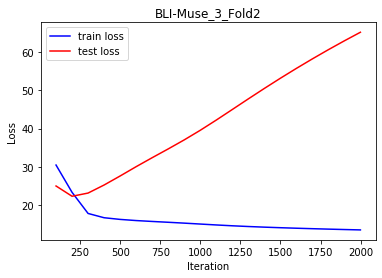

		rmse is 65.07147219831005.
********************
	Fold 3: 


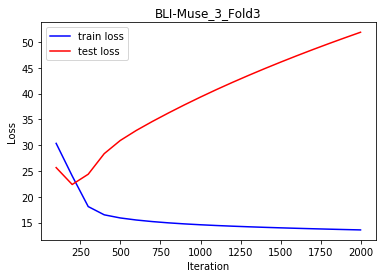

		rmse is 51.86646962196783.
********************
	Fold 4: 


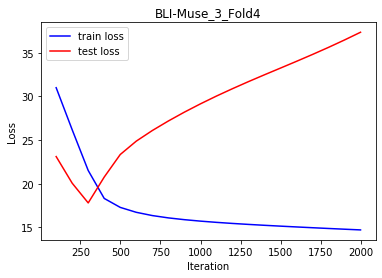

		rmse is 37.35871448108613.
********************
	Fold 5: 


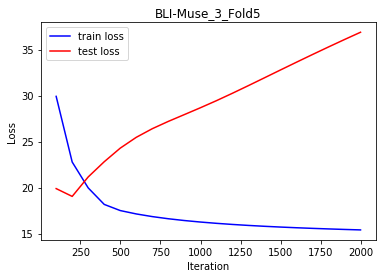

		rmse is 36.88731776773389.
********************
average rmse: 47.947510825808976
----------------------------------------
Vecmap
	Fold 1: 


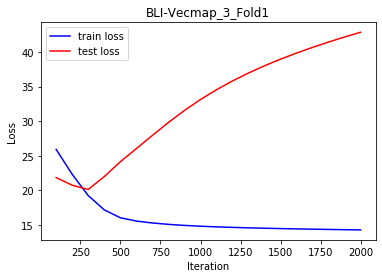

		rmse is 42.862566701181564.
********************
	Fold 2: 


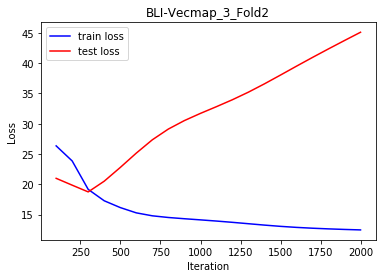

		rmse is 45.11307713311321.
********************
	Fold 3: 


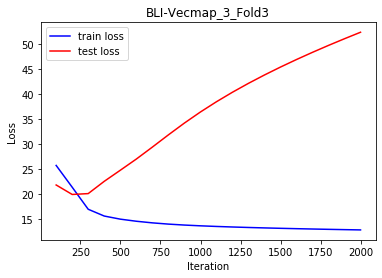

		rmse is 52.304370730542246.
********************
	Fold 4: 


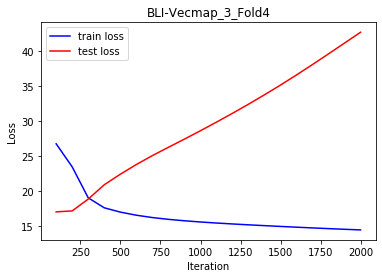

		rmse is 42.75720176118353.
********************
	Fold 5: 


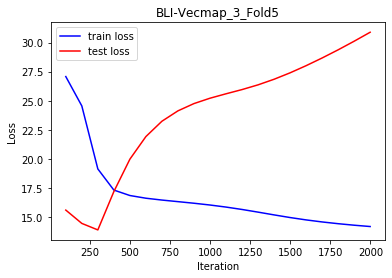

		rmse is 30.882141414074788.
********************
average rmse: 42.783871548019064
num running: 4
----------------------------------------
Muse
	Fold 1: 


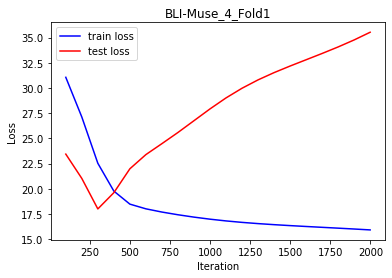

		rmse is 35.52125517307515.
********************
	Fold 2: 


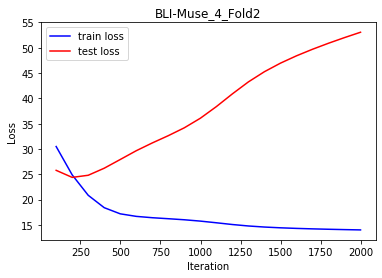

		rmse is 53.059216494985854.
********************
	Fold 3: 


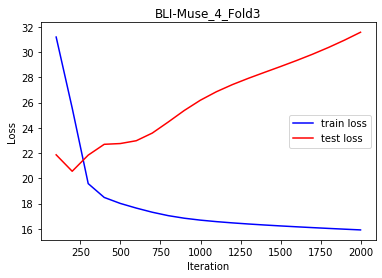

		rmse is 31.56841056883631.
********************
	Fold 4: 


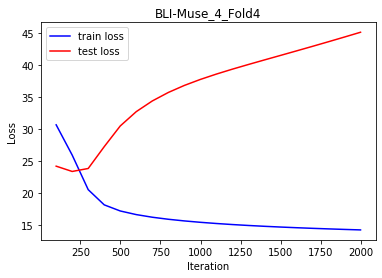

		rmse is 45.10729001088904.
********************
	Fold 5: 


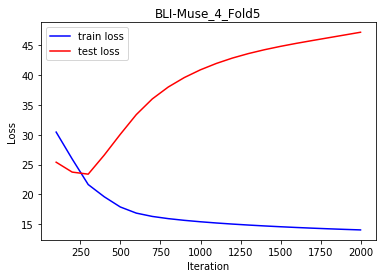

		rmse is 47.139481985263906.
********************
average rmse: 42.47913084661005
----------------------------------------
Vecmap
	Fold 1: 


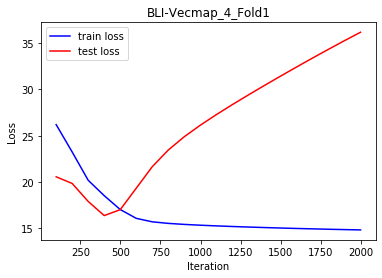

		rmse is 36.180793371357.
********************
	Fold 2: 


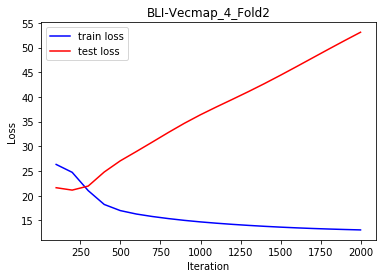

		rmse is 53.100931949206924.
********************
	Fold 3: 


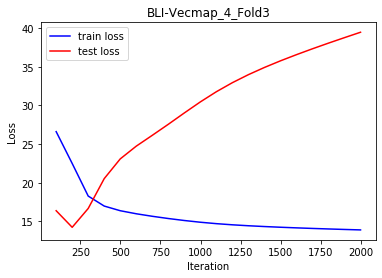

		rmse is 39.45609583449039.
********************
	Fold 4: 


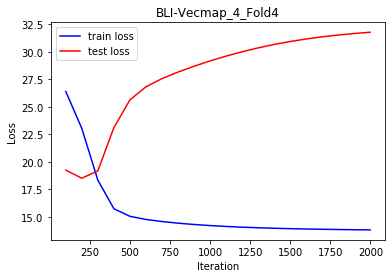

		rmse is 31.770799585459873.
********************
	Fold 5: 


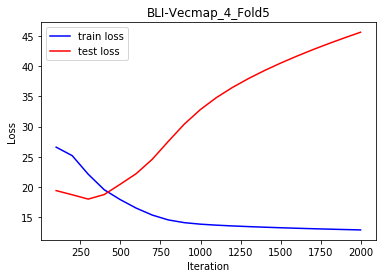

		rmse is 45.606003019702065.
********************
average rmse: 41.222924752043255
num running: 5
----------------------------------------
Muse
	Fold 1: 


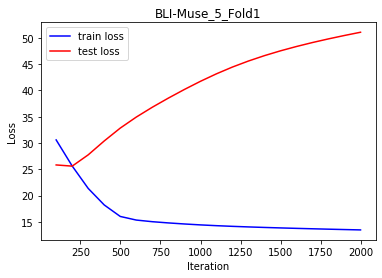

		rmse is 51.06484334514527.
********************
	Fold 2: 


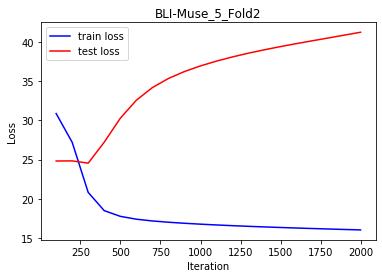

		rmse is 41.254674567941706.
********************
	Fold 3: 


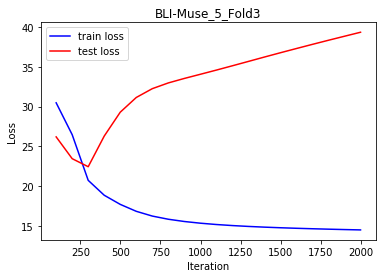

		rmse is 39.36062210853347.
********************
	Fold 4: 


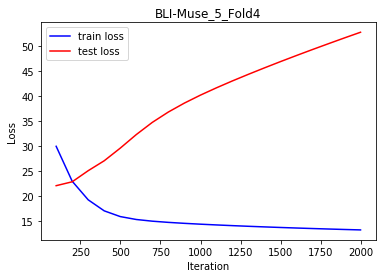

		rmse is 52.80843028540961.
********************
	Fold 5: 


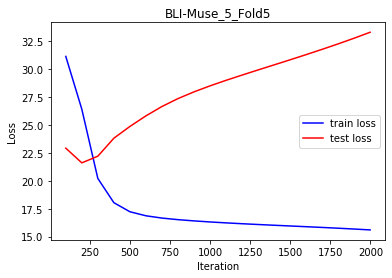

		rmse is 33.29992086455834.
********************
average rmse: 43.55769823431768
----------------------------------------
Vecmap
	Fold 1: 


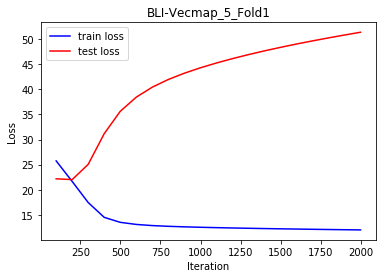

		rmse is 51.357896610671226.
********************
	Fold 2: 


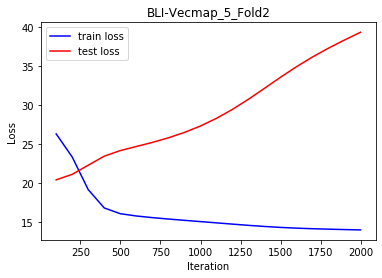

		rmse is 39.300842350752134.
********************
	Fold 3: 


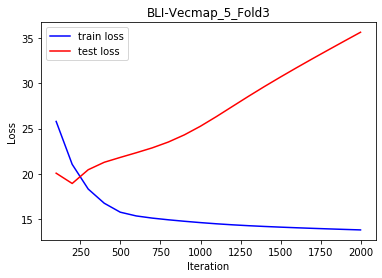

		rmse is 35.6066102178187.
********************
	Fold 4: 


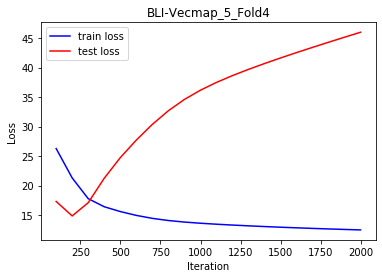

		rmse is 45.98520642929186.
********************
	Fold 5: 


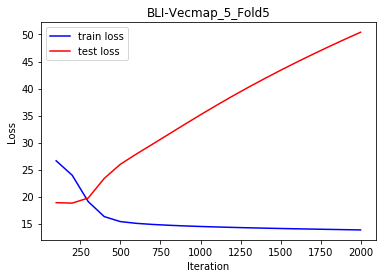

		rmse is 50.416644033601074.
********************
average rmse: 44.533439928427
num running: 6
----------------------------------------
Muse
	Fold 1: 


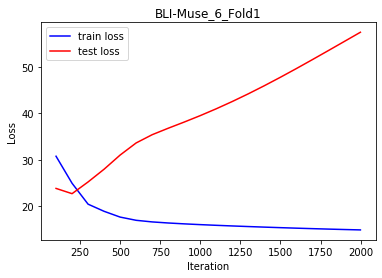

		rmse is 57.41246546456652.
********************
	Fold 2: 


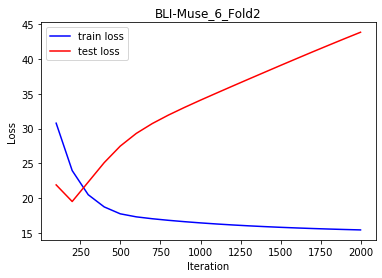

		rmse is 43.872510349208596.
********************
	Fold 3: 


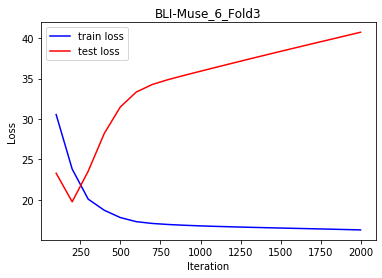

		rmse is 40.71254553451248.
********************
	Fold 4: 


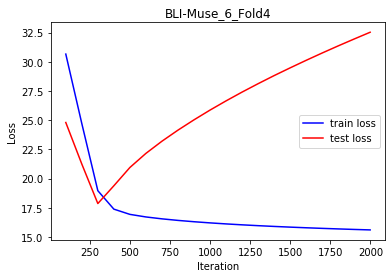

		rmse is 32.52683387757425.
********************
	Fold 5: 


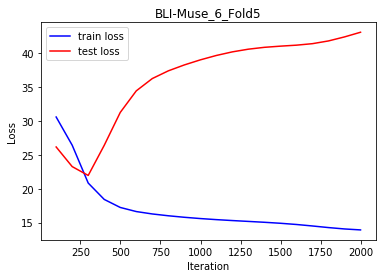

		rmse is 43.11122366154323.
********************
average rmse: 43.52711577748101
----------------------------------------
Vecmap
	Fold 1: 


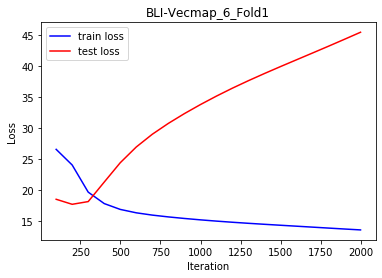

		rmse is 45.48873173350884.
********************
	Fold 2: 


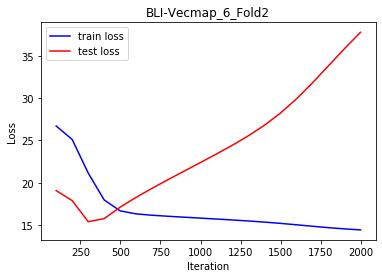

		rmse is 37.79942836521996.
********************
	Fold 3: 


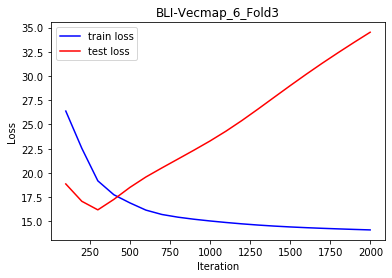

		rmse is 34.52180908021586.
********************
	Fold 4: 


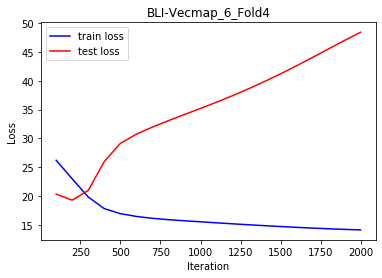

		rmse is 48.40397001277649.
********************
	Fold 5: 


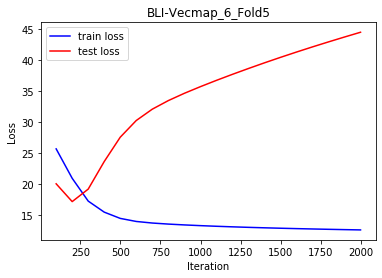

		rmse is 44.52088613532842.
********************
average rmse: 42.146965065409915
num running: 7
----------------------------------------
Muse
	Fold 1: 


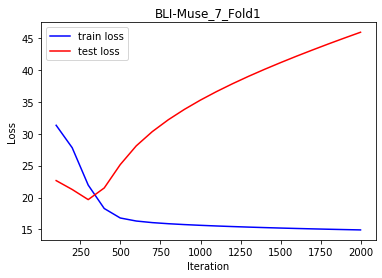

		rmse is 45.87691930383437.
********************
	Fold 2: 


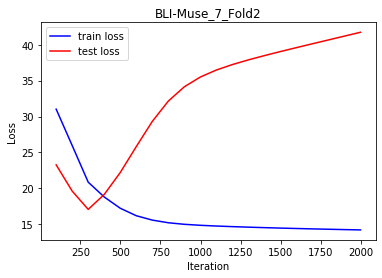

		rmse is 41.74692536534645.
********************
	Fold 3: 


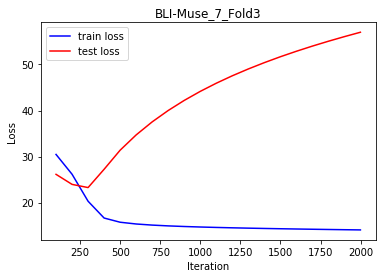

		rmse is 56.99314577791.
********************
	Fold 4: 


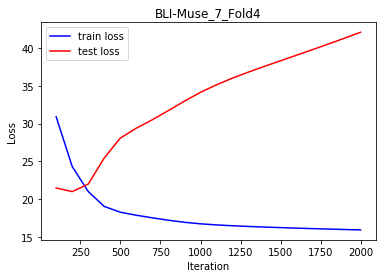

		rmse is 42.071110521366805.
********************
	Fold 5: 


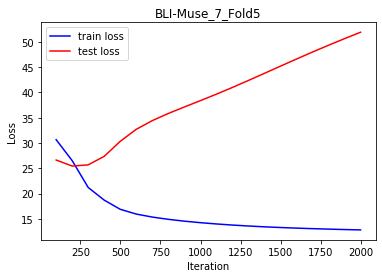

		rmse is 51.892805049165034.
********************
average rmse: 47.71618120352453
----------------------------------------
Vecmap
	Fold 1: 


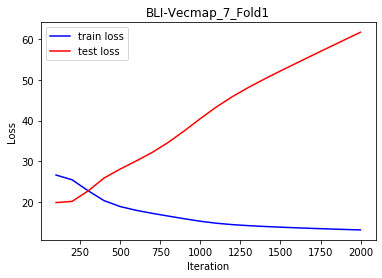

		rmse is 61.65171171011463.
********************
	Fold 2: 


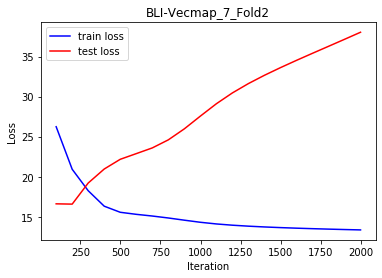

		rmse is 38.032121297731656.
********************
	Fold 3: 


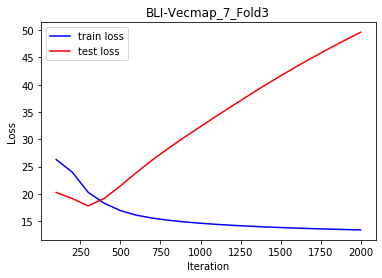

		rmse is 49.625713524635295.
********************
	Fold 4: 


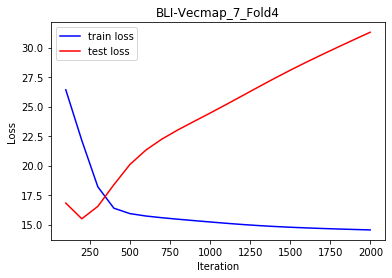

		rmse is 31.305955617342857.
********************
	Fold 5: 


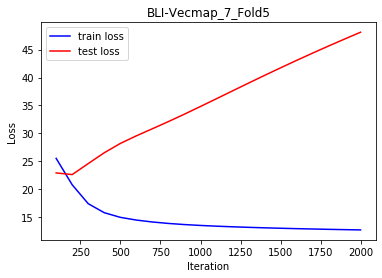

		rmse is 48.105435668954726.
********************
average rmse: 45.74418756375583
num running: 8
----------------------------------------
Muse
	Fold 1: 


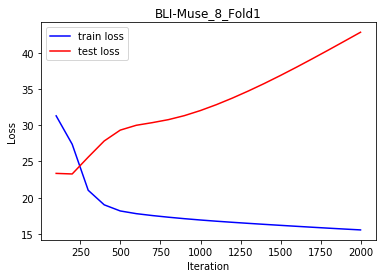

		rmse is 42.822958709329974.
********************
	Fold 2: 


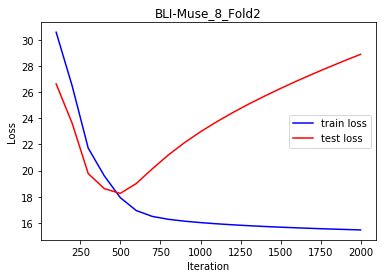

		rmse is 28.880236150144036.
********************
	Fold 3: 


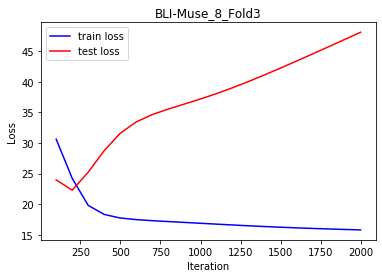

		rmse is 48.07397921384933.
********************
	Fold 4: 


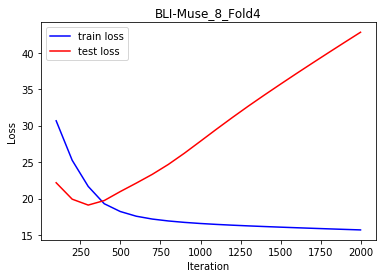

		rmse is 42.811124169070276.
********************
	Fold 5: 


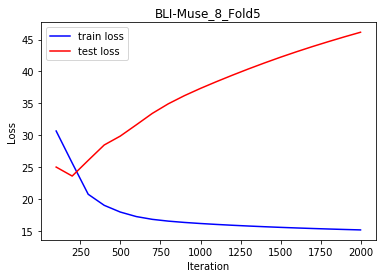

		rmse is 46.15435619723685.
********************
average rmse: 41.748530887926094
----------------------------------------
Vecmap
	Fold 1: 


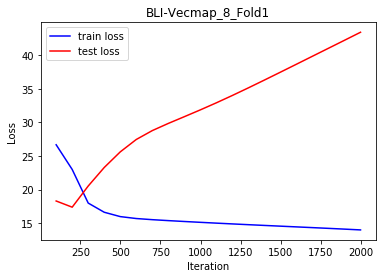

		rmse is 43.3994459089317.
********************
	Fold 2: 


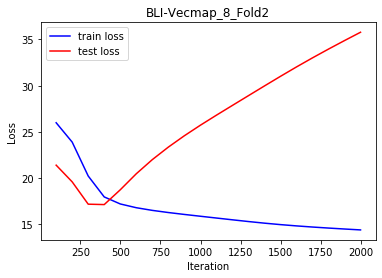

		rmse is 35.78462249441022.
********************
	Fold 3: 


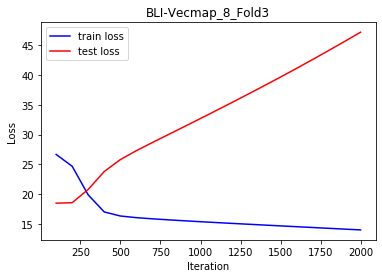

		rmse is 47.14633142650657.
********************
	Fold 4: 


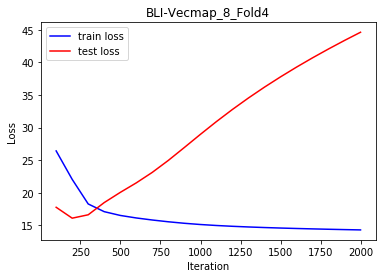

		rmse is 44.632773811862805.
********************
	Fold 5: 


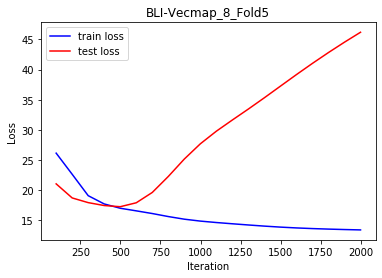

		rmse is 46.17611930563087.
********************
average rmse: 43.427858589468435
num running: 9
----------------------------------------
Muse
	Fold 1: 


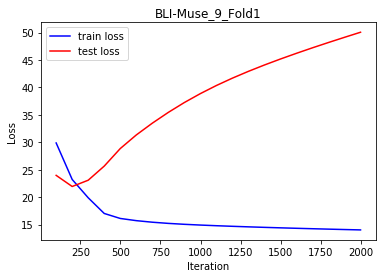

		rmse is 50.05996691400399.
********************
	Fold 2: 


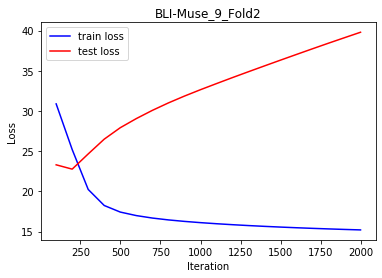

		rmse is 39.78586480302442.
********************
	Fold 3: 


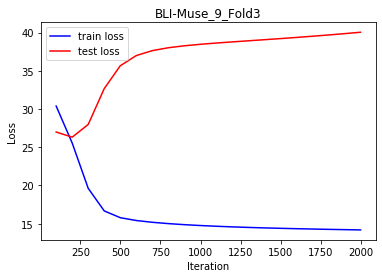

		rmse is 40.033854999918674.
********************
	Fold 4: 


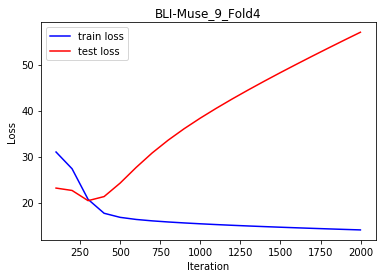

		rmse is 57.04737933514639.
********************
	Fold 5: 


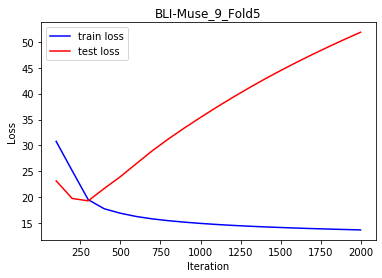

		rmse is 51.87423749470517.
********************
average rmse: 47.76026070935973
----------------------------------------
Vecmap
	Fold 1: 


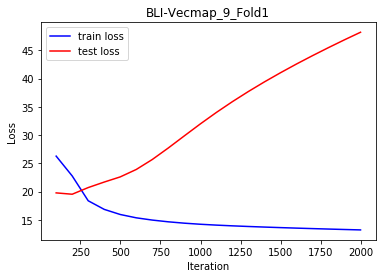

		rmse is 48.203135319029684.
********************
	Fold 2: 


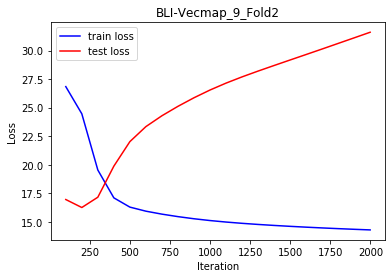

		rmse is 31.60448621090199.
********************
	Fold 3: 


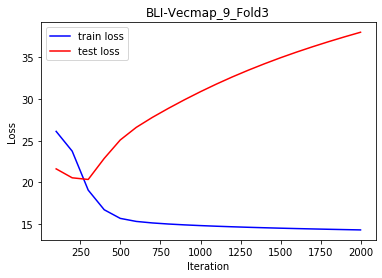

		rmse is 38.02706207625015.
********************
	Fold 4: 


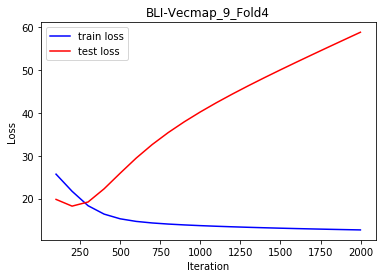

		rmse is 58.88454461655757.
********************
	Fold 5: 


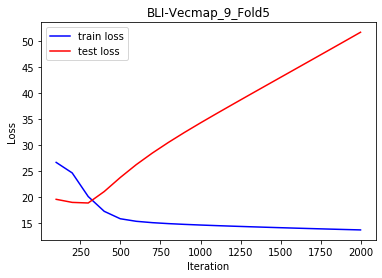

		rmse is 51.66161309951485.
********************
average rmse: 45.67616826445085
num running: 10
----------------------------------------
Muse
	Fold 1: 


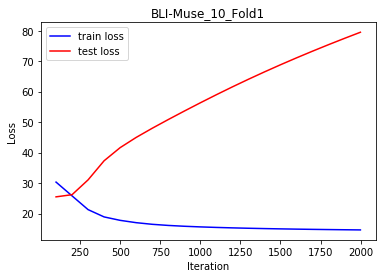

		rmse is 79.48452920472013.
********************
	Fold 2: 


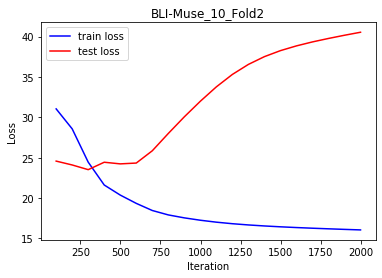

		rmse is 40.533681211203934.
********************
	Fold 3: 


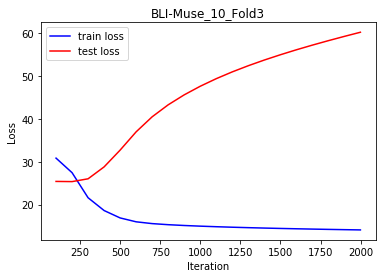

		rmse is 60.22185930117856.
********************
	Fold 4: 


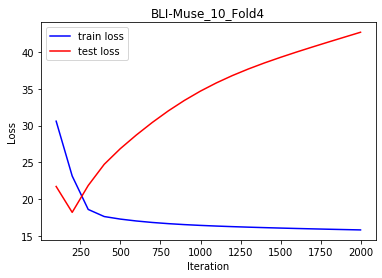

		rmse is 42.669608957779616.
********************
	Fold 5: 


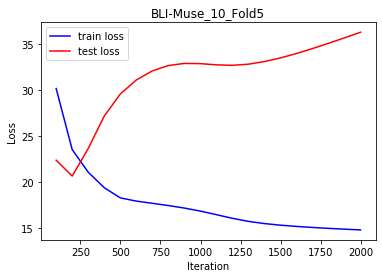

		rmse is 36.28418875978674.
********************
average rmse: 51.8387734869338
----------------------------------------
Vecmap
	Fold 1: 


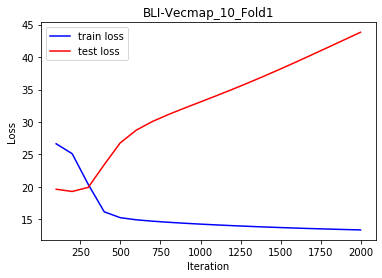

		rmse is 43.81357763984353.
********************
	Fold 2: 


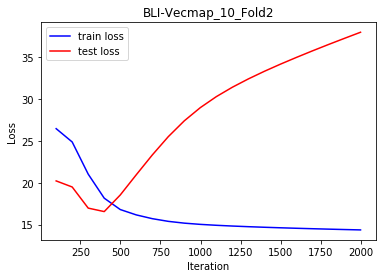

		rmse is 37.9908457164307.
********************
	Fold 3: 


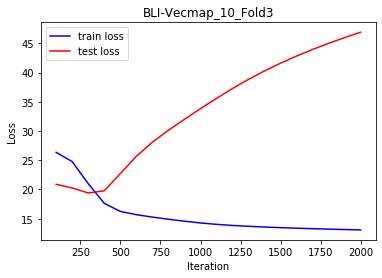

		rmse is 46.8901685694692.
********************
	Fold 4: 


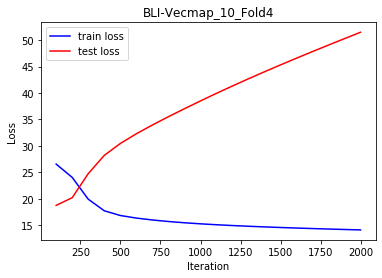

		rmse is 51.476576115267946.
********************
	Fold 5: 


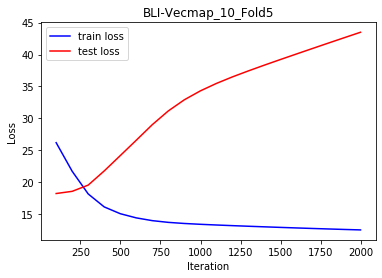

		rmse is 43.49756491444239.
********************
average rmse: 44.73374659109075


In [5]:
WIKI_MT_DIR = "../data/data_wiki_new.csv"
WIKI_SRC = "Source"
WIKI_TGT = "Target"
WIKI_SCORE = ["BLEU"]
WIKI_SIDE_FEATURES = ['geographic', 'genetic', 'inventory', 'syntactic', 'phonological', 'featural']
WIKI_ALPHA = 0.0001
WIKI_BETA = 0.1

BLI_DIR = "../data/data_bli2_new.csv"
BLI_SRC = "Source Language Code"
BLI_TGT = "Target Language Code"
BLI_SCORE = ["Muse", "Vecmap"]
BLI_SIDE_FEATURES = ['genetic', 'syntactic', 'featural', 'phonological', 'inventory', 'geographic']
BLI_ALPHA = 0.0001
BLI_BETA = 0.0005
# The score metric is from "NLPerf/src/task_feats.py"

k = 5
num_running = 10

WIKI_SIDE_INFO_DICT = get_language_pair_side_info(WIKI_MT_DIR, WIKI_SIDE_FEATURES, WIKI_SRC, WIKI_TGT)
WIKI_SRC_SIDE_INFO_DICT, WIKI_TGT_SIDE_INFO_DICT = get_language_side_information(WIKI_MT_DIR, WIKI_SRC, WIKI_TGT)

BLI_SIDE_INFO_DICT = get_language_pair_side_info(BLI_DIR, BLI_SIDE_FEATURES, BLI_SRC, BLI_TGT)
BLI_SRC_SIDE_INFO_DICT, BLI_TGT_SIDE_INFO_DICT = get_language_side_information(BLI_DIR, BLI_SRC, BLI_TGT)

wiki_result = get_result(WIKI_ALPHA, WIKI_BETA, WIKI_MT_DIR, WIKI_SCORE, WIKI_SRC, WIKI_TGT, k, num_running)
bli_result = get_result(BLI_ALPHA, BLI_BETA, BLI_DIR, BLI_SCORE, BLI_SRC, BLI_TGT, k, num_running)

# wiki_mt_score_matrix = generate_score_matrix(WIKI_MT_DIR, "Source", "Target", "BLEU")
# wiki_mt_score_matrix, wiki_mt_valid = generate_score_matrix(WIKI_MT_DIR, "Source", "Target", "BLEU")xdz
# bli_score_matrix, bli_valid = generate_score_matrix(BLI_DIR, "Source Language Code", "Target Language Code", ["Muse", "Vecmap"])

In [6]:
print(wiki_result)
print(bli_result)

15.902377608716108
44.23205366794421
